# **Bibliotecas**

In [1]:
%%capture

!pip install shap
!pip install optuna

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [5]:
# Leitura dos dados de colo de útero
df_pulmao = pd.read_csv('pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


In [6]:
# Valores faltantes
df_pulmao.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [7]:
df_pulmao_ano5 = df_pulmao[~((df_pulmao.obito_geral == 0) & (df_pulmao.sobrevida_ano5 == 0))].reset_index(drop=True)
df_pulmao_ano5.shape

(35693, 32)

In [8]:
# Correlação com a saída
corr_matrix = df_pulmao_ano5.corr()
abs(corr_matrix['sobrevida_ano5']).sort_values(ascending = False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano5      1.000000
sobrevida_ano3      0.755249
obito_geral         0.736522
sobrevida_ano1      0.351268
CIRURGIA            0.323971
DIAGTRAT            0.106624
NENHUM              0.106270
TRATCONS            0.106239
CONSDIAG            0.080919
ESCOLARI_preench    0.068745
IDADE               0.061597
presenca_rec        0.055877
SEXO                0.055415
OUTROS              0.051312
QUIMIO              0.045946
ANODIAG             0.037747
RADIO               0.036159
CATEATEND           0.034589
DIAGPREV            0.031536
IBGEATEN            0.030129
Name: sobrevida_ano5, dtype: float64

In [9]:
# Quantidade de pacientes em cada classe da saída
df_pulmao_ano5.sobrevida_ano5.value_counts()

0    33335
1     2358
Name: sobrevida_ano5, dtype: int64

## **Pré-processamento**

In [10]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano3']

lb = 'sobrevida_ano5'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_pulmao_ano5,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (26769, 25), X_test = (8924, 25)
y_train = (26769,), y_test = (8924,)


In [11]:
y_train.value_counts(normalize=True)

0    0.933953
1    0.066047
Name: sobrevida_ano5, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.933886
1    0.066114
Name: sobrevida_ano5, dtype: float64

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo base**

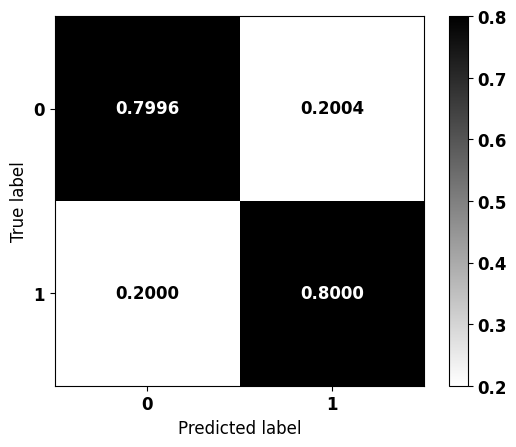


              precision    recall  f1-score   support

           0     0.9826    0.7996    0.8817      8334
           1     0.2204    0.8000    0.3455       590

    accuracy                         0.7996      8924
   macro avg     0.6015    0.7998    0.6136      8924
weighted avg     0.9322    0.7996    0.8463      8924



In [13]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:1, 1:20.11},
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

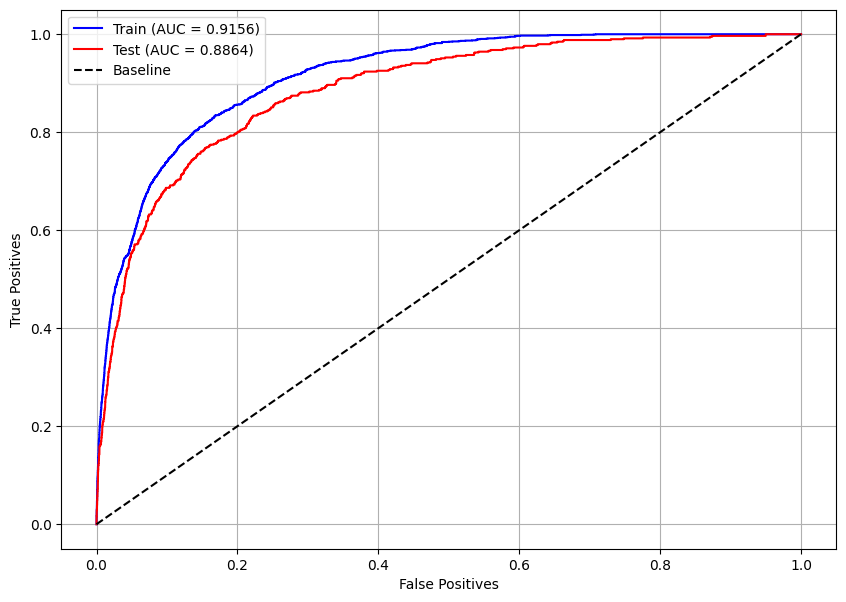

In [14]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

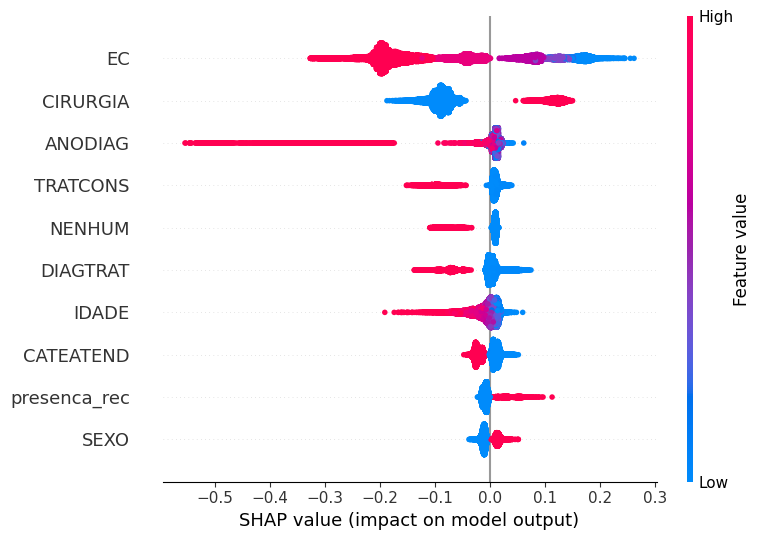

In [15]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [32]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [18]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=16, state=TrialState.COMPLETE, values=[0.9398931438880614], datetime_start=datetime.datetime(2023, 10, 17, 12, 22, 58, 153956), datetime_complete=datetime.datetime(2023, 10, 17, 12, 23, 13, 180631), params={'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_samples': 0.8999999999999999, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=8, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=16, value=None)

In [19]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 55,
 'max_depth': 8,
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_samples': 0.8999999999999999,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(20, 20.4, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:1, 1:i}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

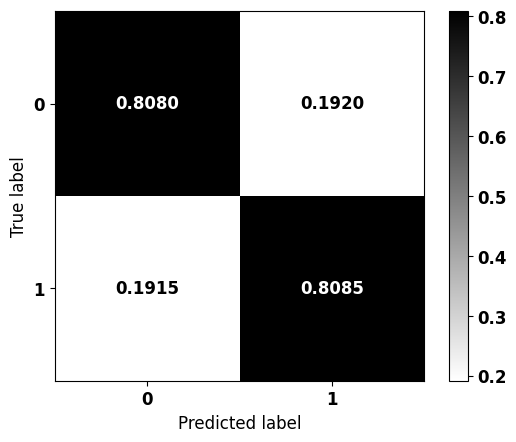


              precision    recall  f1-score   support

           0     0.9835    0.8080    0.8872      8334
           1     0.2297    0.8085    0.3577       590

    accuracy                         0.8080      8924
   macro avg     0.6066    0.8082    0.6224      8924
weighted avg     0.9337    0.8080    0.8522      8924



In [21]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:20.132}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

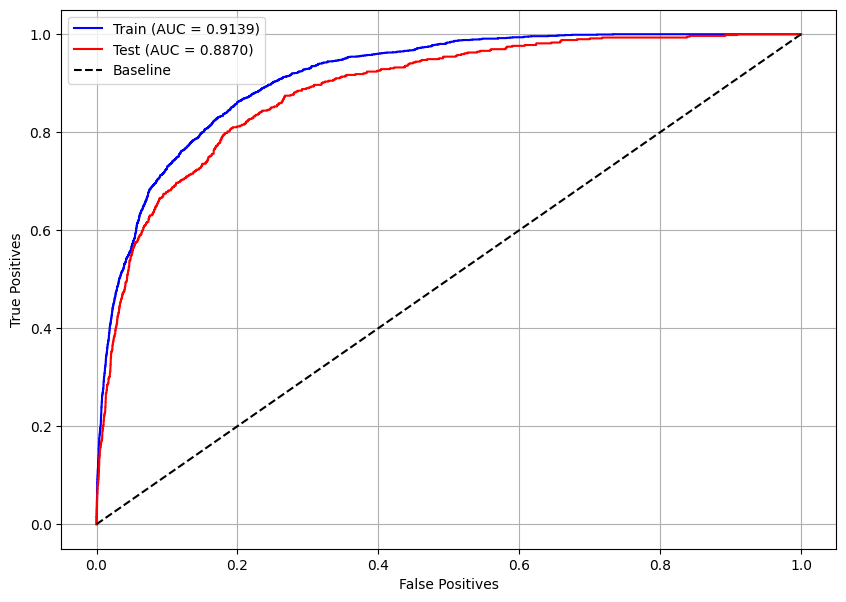

In [22]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [24]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 93,
 'max_depth': 8,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_samples': 1.0,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(20, 20.4, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:1, 1:i}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

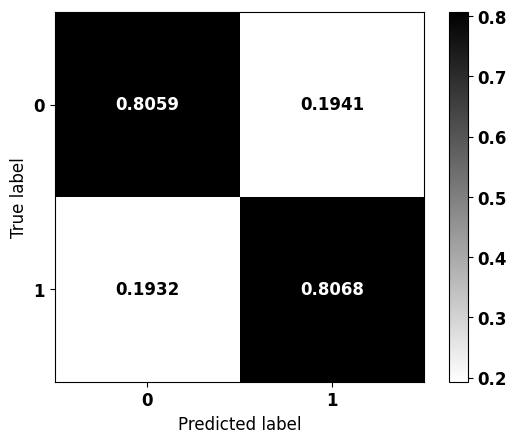


              precision    recall  f1-score   support

           0     0.9833    0.8059    0.8858      8334
           1     0.2273    0.8068    0.3547       590

    accuracy                         0.8059      8924
   macro avg     0.6053    0.8063    0.6202      8924
weighted avg     0.9333    0.8059    0.8507      8924



In [27]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:20.185}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

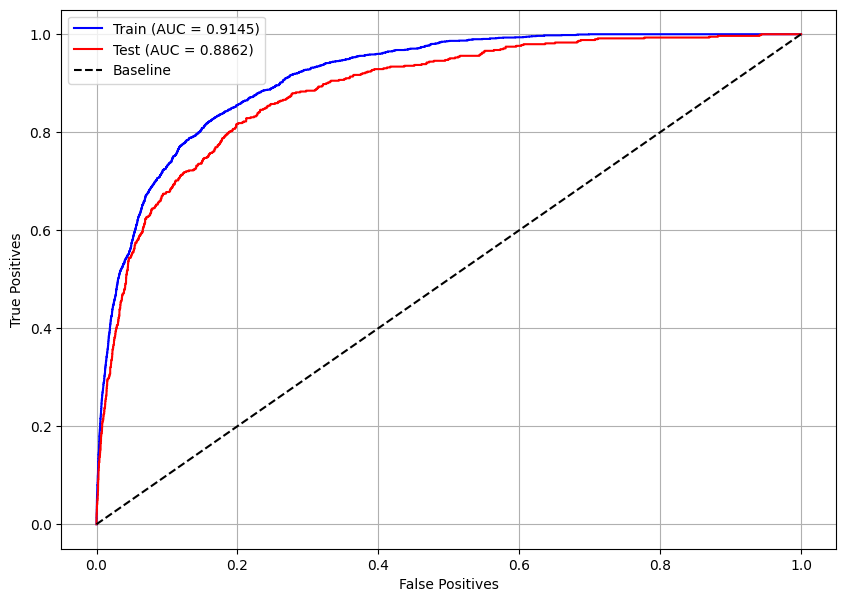

In [28]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [37]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 85,
 'max_depth': 8,
 'min_samples_split': 10,
 'min_samples_leaf': 7,
 'max_samples': 0.7999999999999999}

In [ ]:
pesos = np.round(np.arange(21, 21.1, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:1, 1:i}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

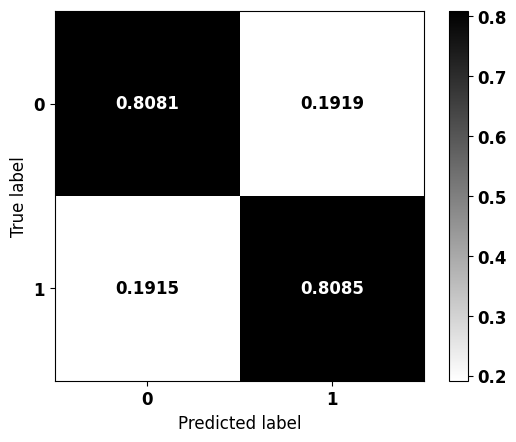


              precision    recall  f1-score   support

           0     0.9835    0.8081    0.8872      8334
           1     0.2298    0.8085    0.3578       590

    accuracy                         0.8082      8924
   macro avg     0.6066    0.8083    0.6225      8924
weighted avg     0.9337    0.8082    0.8522      8924



In [64]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:21.062}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

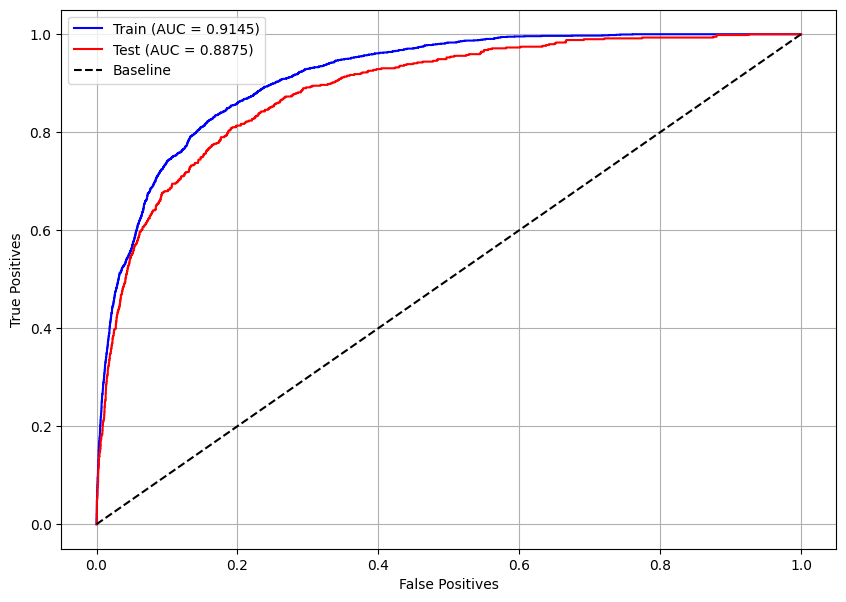

In [65]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

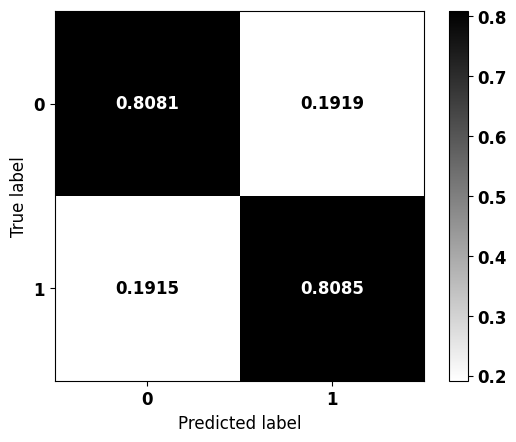


              precision    recall  f1-score   support

           0     0.9835    0.8081    0.8872      8334
           1     0.2298    0.8085    0.3578       590

    accuracy                         0.8082      8924
   macro avg     0.6066    0.8083    0.6225      8924
weighted avg     0.9337    0.8082    0.8522      8924



In [66]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 85, 'max_depth': 8, 'min_samples_split': 10,
          'min_samples_leaf': 7, 'max_samples': 0.8}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:21.062}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

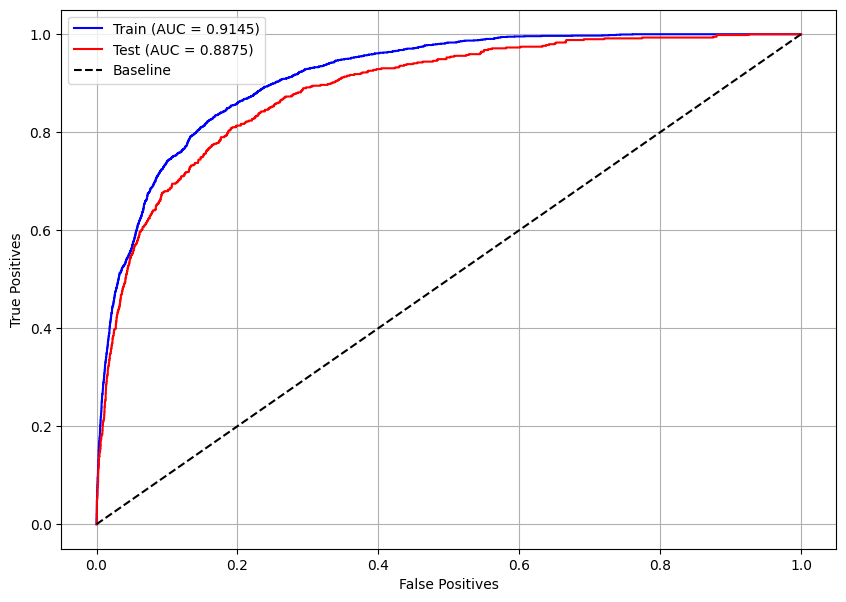

In [67]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

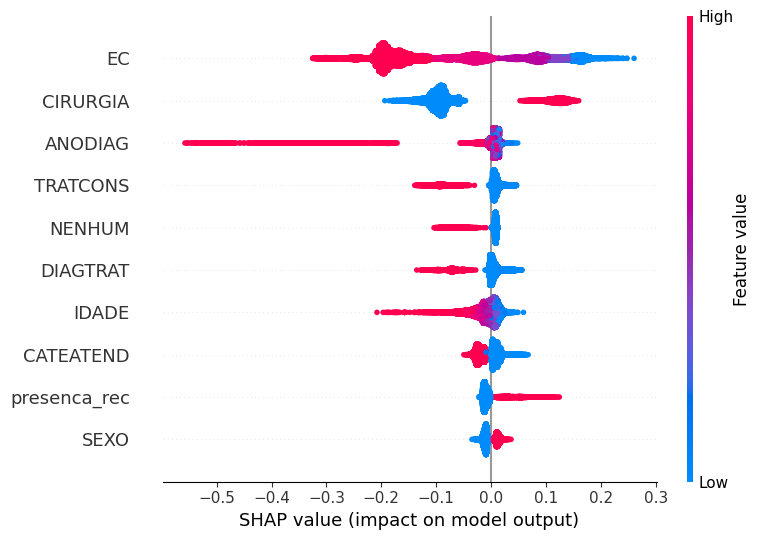

In [68]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo base**

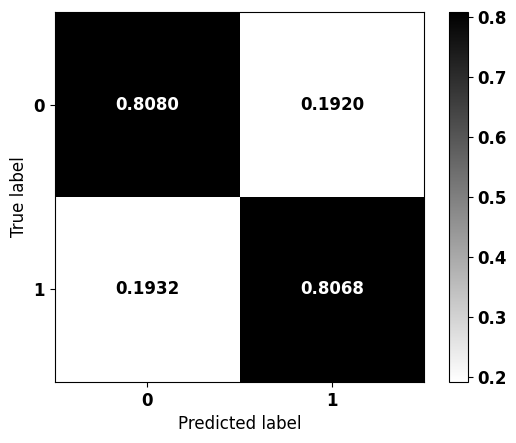


              precision    recall  f1-score   support

           0     0.9834    0.8080    0.8871      8334
           1     0.2293    0.8068    0.3571       590

    accuracy                         0.8079      8924
   macro avg     0.6063    0.8074    0.6221      8924
weighted avg     0.9335    0.8079    0.8521      8924



In [78]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=18.174,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

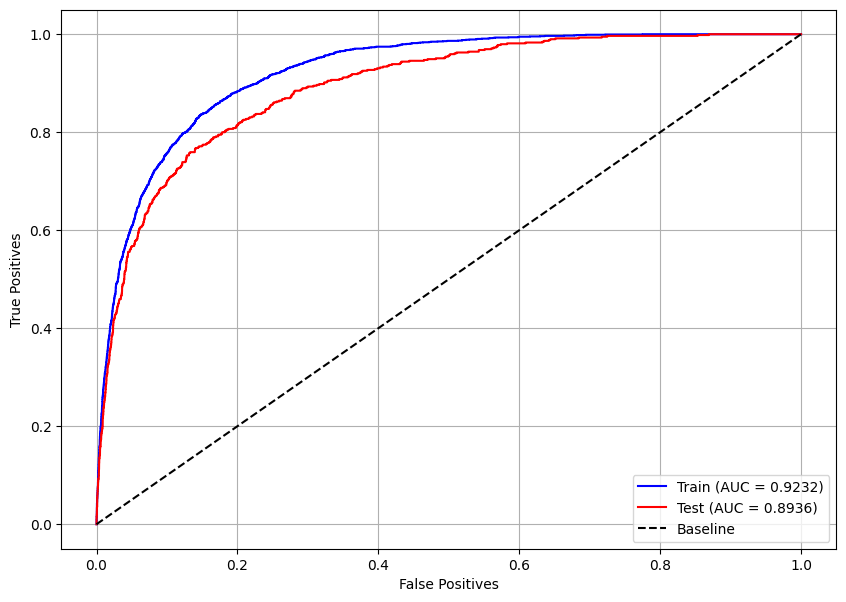

In [79]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

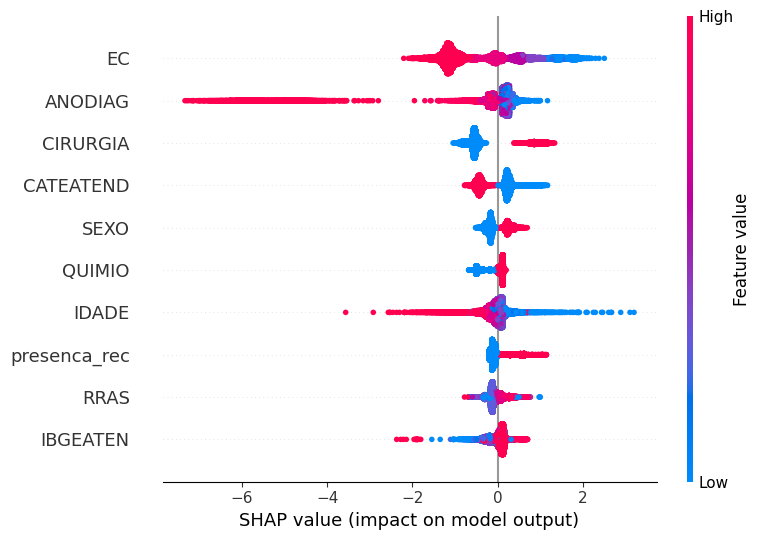

In [80]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [93]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [97]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=31, state=TrialState.COMPLETE, values=[0.9421719257161012], datetime_start=datetime.datetime(2023, 10, 17, 14, 21, 15, 186443), datetime_complete=datetime.datetime(2023, 10, 17, 14, 21, 20, 237469), params={'n_estimators': 121, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 3, 'colsample_bytree': 0.7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=5, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=31, value=None)

In [98]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 121,
 'max_depth': 3,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 3,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(17, 17.1, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

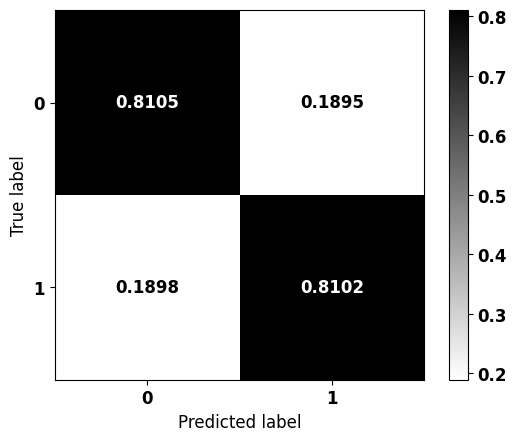


              precision    recall  f1-score   support

           0     0.9837    0.8105    0.8888      8334
           1     0.2324    0.8102    0.3612       590

    accuracy                         0.8105      8924
   macro avg     0.6080    0.8104    0.6250      8924
weighted avg     0.9340    0.8105    0.8539      8924



In [110]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 17.056

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

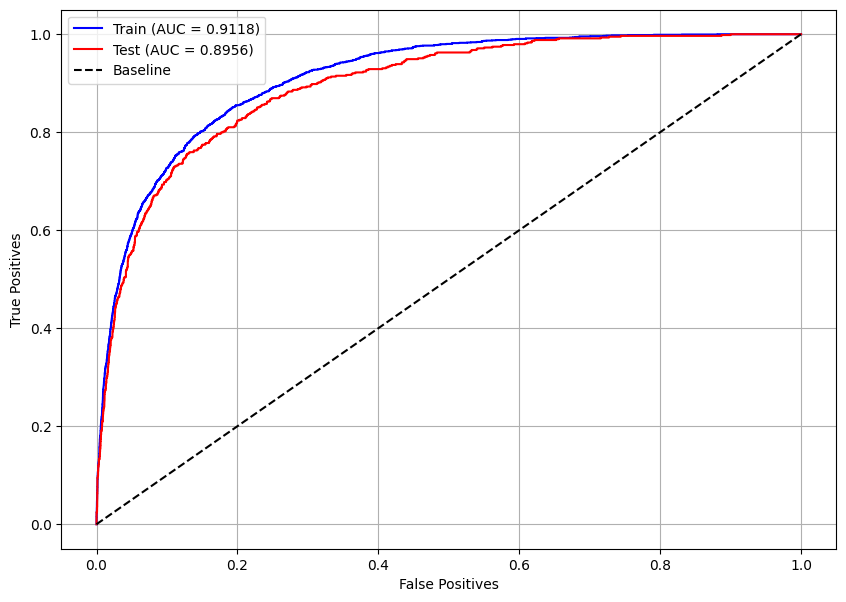

In [111]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [113]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 74,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'min_child_weight': 3,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(17.3, 17.6, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

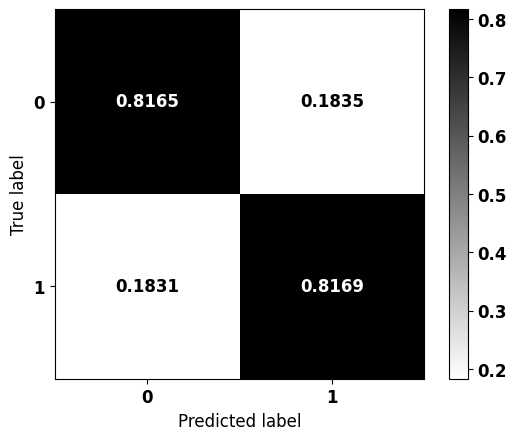


              precision    recall  f1-score   support

           0     0.9844    0.8165    0.8926      8334
           1     0.2397    0.8169    0.3706       590

    accuracy                         0.8166      8924
   macro avg     0.6120    0.8167    0.6316      8924
weighted avg     0.9351    0.8166    0.8581      8924



In [117]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 17.436

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

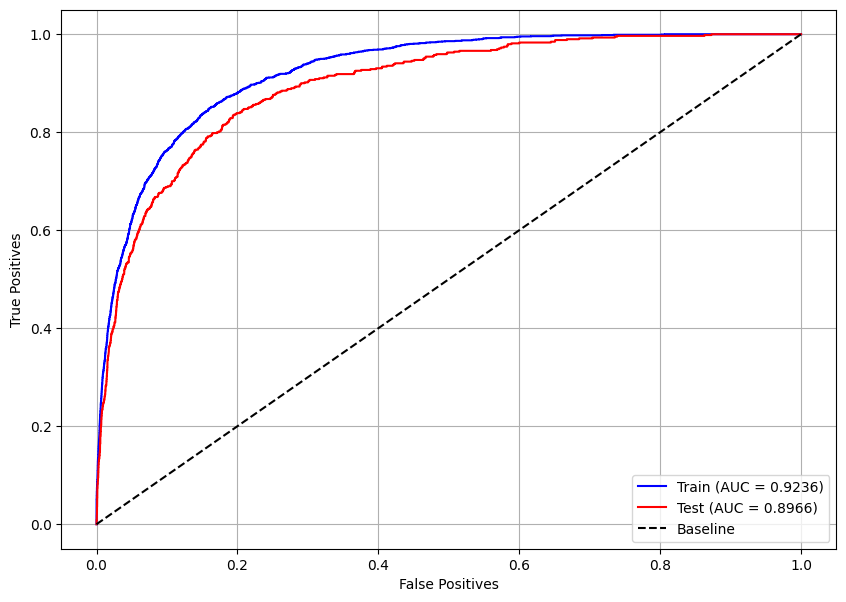

In [118]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [120]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 90,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(18.1, 18.3, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

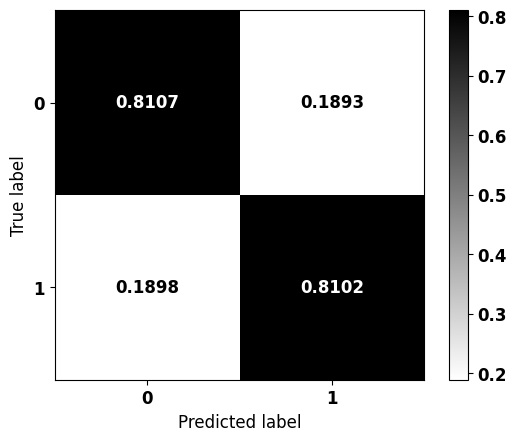


              precision    recall  f1-score   support

           0     0.9837    0.8107    0.8888      8334
           1     0.2325    0.8102    0.3613       590

    accuracy                         0.8106      8924
   macro avg     0.6081    0.8104    0.6251      8924
weighted avg     0.9340    0.8106    0.8540      8924



In [122]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 18.25

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

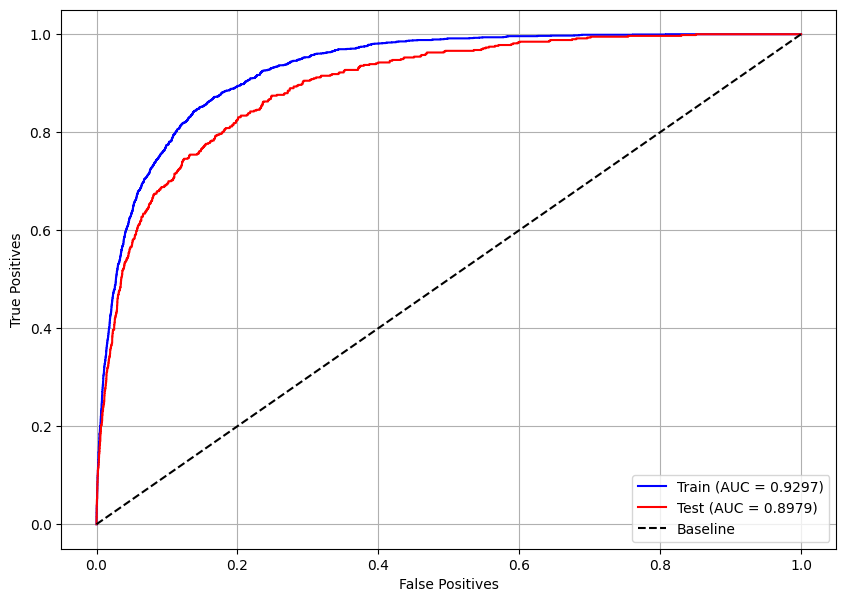

In [123]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

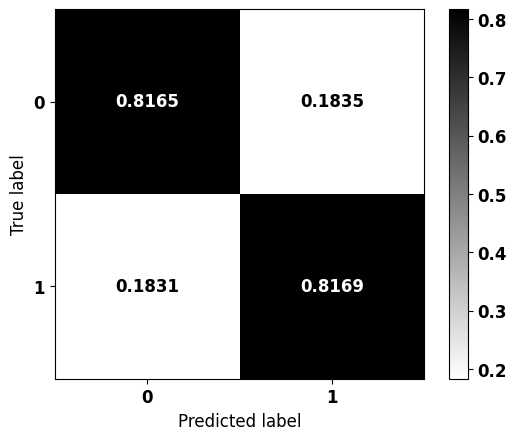


              precision    recall  f1-score   support

           0     0.9844    0.8165    0.8926      8334
           1     0.2397    0.8169    0.3706       590

    accuracy                         0.8166      8924
   macro avg     0.6120    0.8167    0.6316      8924
weighted avg     0.9351    0.8166    0.8581      8924



In [124]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 74, 'max_depth': 5, 'learning_rate': 0.1,
          'gamma': 0.0, 'min_child_weight': 3, 'colsample_bytree': 0.7}

params['random_state'] = seed
params['scale_pos_weight'] = 17.436

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

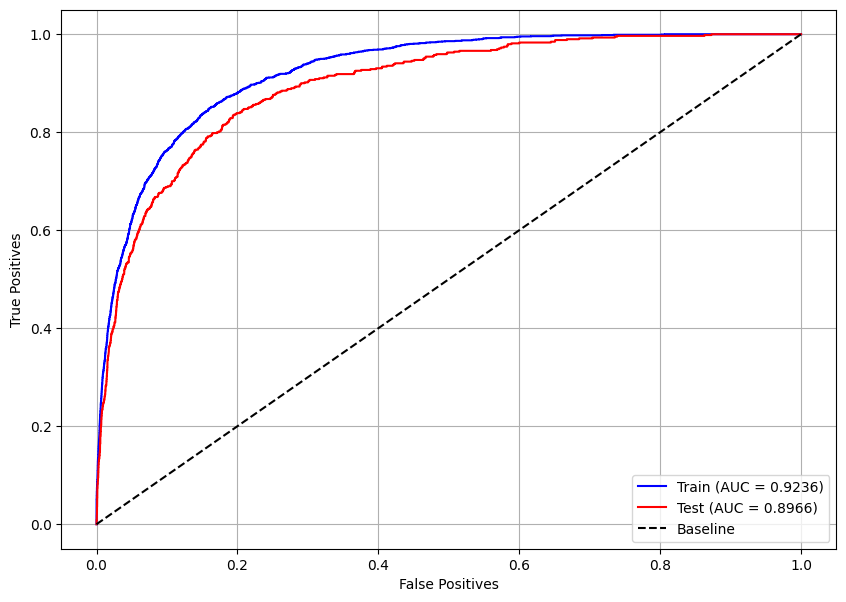

In [125]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

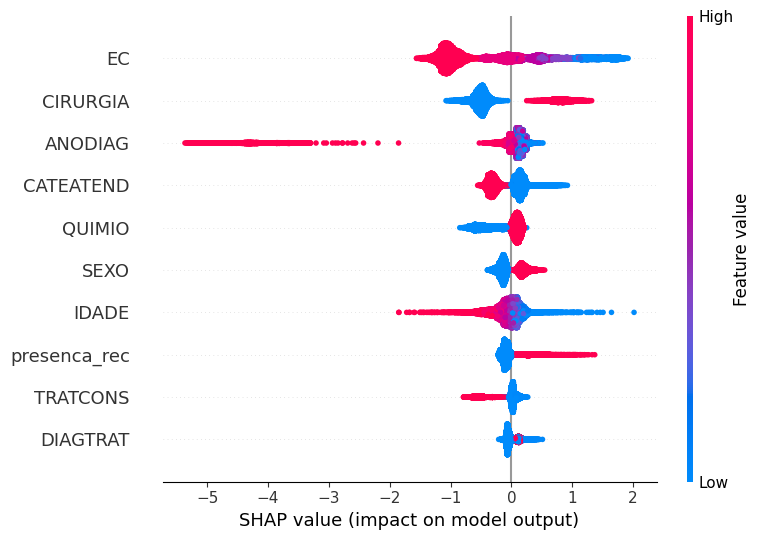

In [126]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo base**

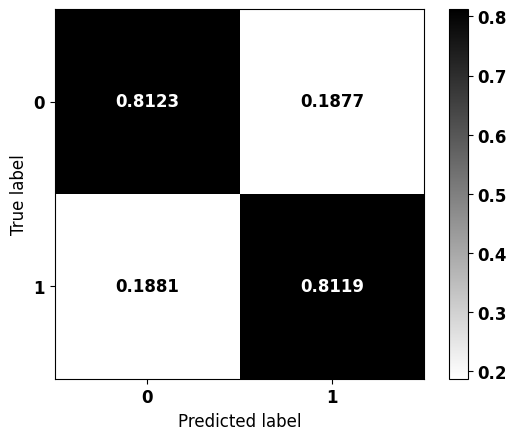


              precision    recall  f1-score   support

           0     0.9839    0.8123    0.8899      8334
           1     0.2345    0.8119    0.3638       590

    accuracy                         0.8123      8924
   macro avg     0.6092    0.8121    0.6269      8924
weighted avg     0.9343    0.8123    0.8551      8924



In [127]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=5,
                      class_weight={0:1, 1:19.02},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

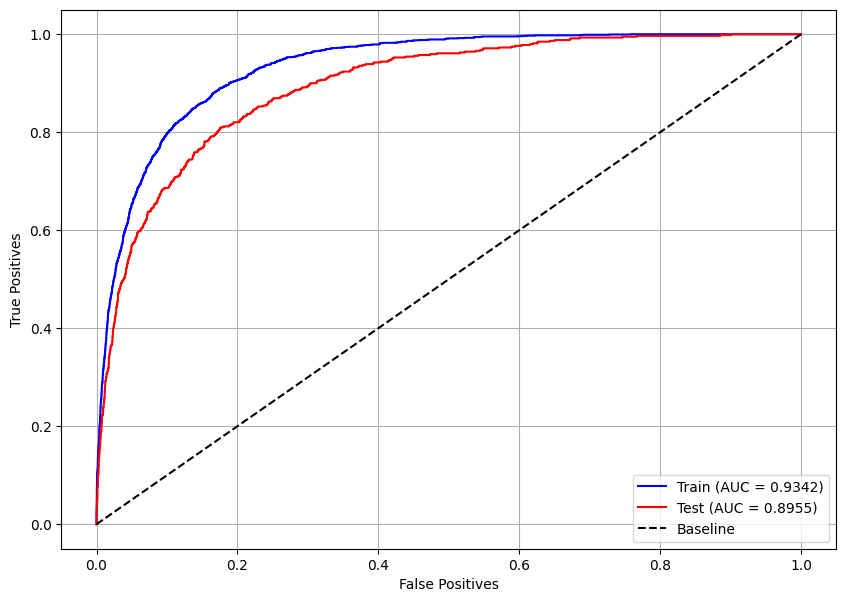

In [128]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

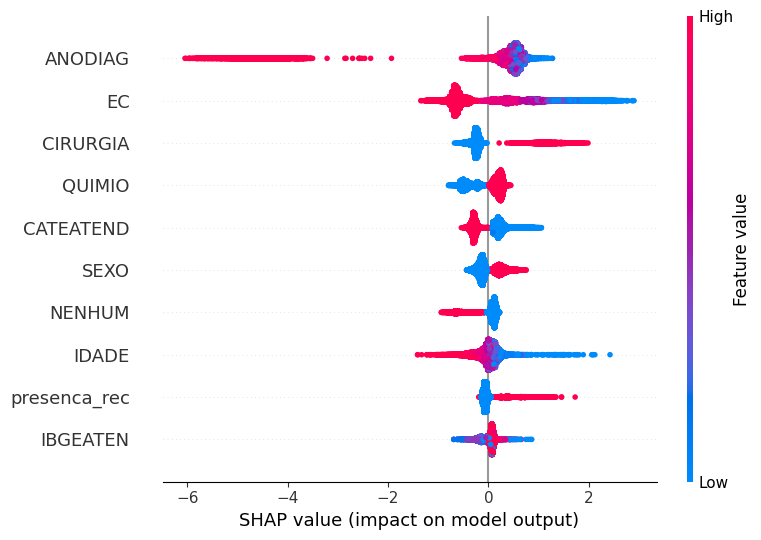

In [129]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [130]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelo e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [132]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=55, state=TrialState.COMPLETE, values=[0.9420971733411954], datetime_start=datetime.datetime(2023, 10, 17, 14, 54, 37, 249255), datetime_complete=datetime.datetime(2023, 10, 17, 14, 54, 44, 378289), params={'n_estimators': 96, 'max_depth': 4, 'learning_rate': 0.09, 'min_child_weight': 4, 'colsample_bytree': 0.6000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=5, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=55, value=None)

In [133]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 96,
 'max_depth': 4,
 'learning_rate': 0.09,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(16.25, 16.75, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

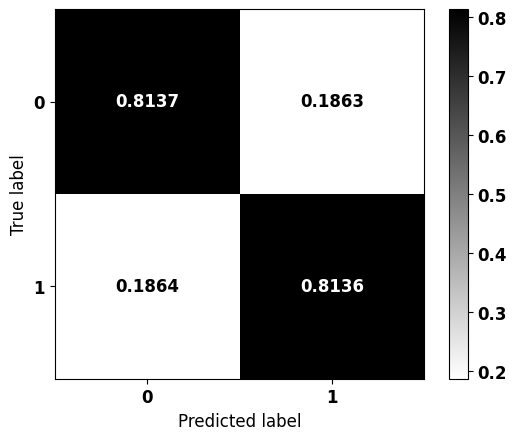


              precision    recall  f1-score   support

           0     0.9840    0.8137    0.8908      8334
           1     0.2361    0.8136    0.3660       590

    accuracy                         0.8136      8924
   macro avg     0.6101    0.8136    0.6284      8924
weighted avg     0.9346    0.8136    0.8561      8924



In [140]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:16.48}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

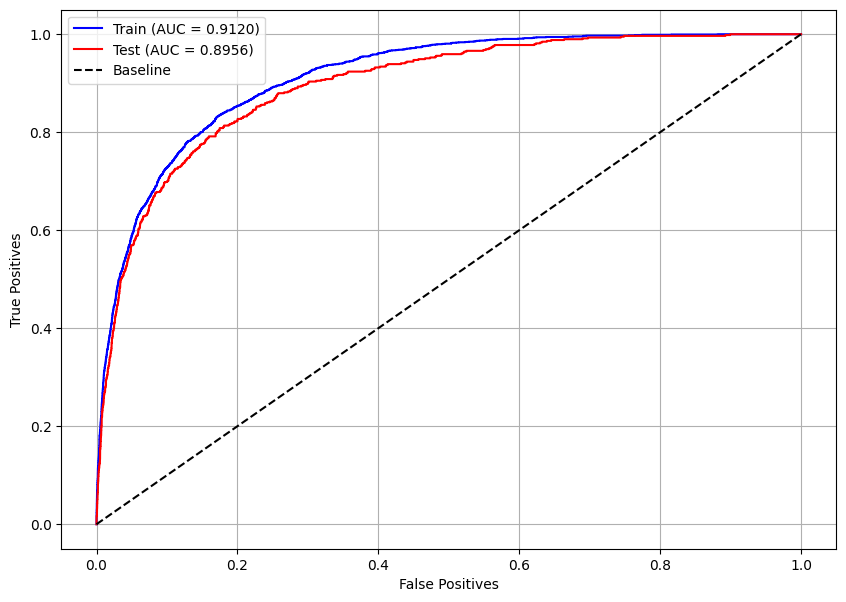

In [141]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [143]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 150,
 'max_depth': 5,
 'learning_rate': 0.13,
 'min_child_weight': 2,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(21.2, 21.4, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

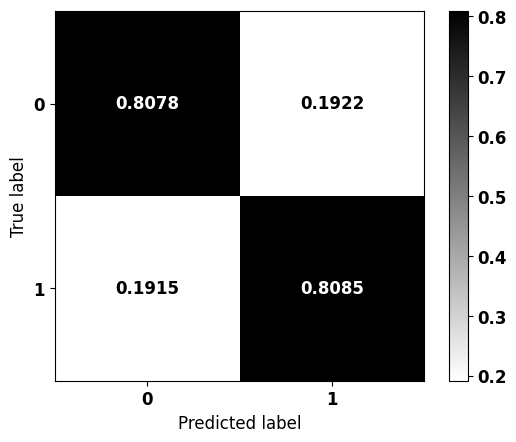


              precision    recall  f1-score   support

           0     0.9835    0.8078    0.8870      8334
           1     0.2294    0.8085    0.3574       590

    accuracy                         0.8078      8924
   macro avg     0.6065    0.8081    0.6222      8924
weighted avg     0.9336    0.8078    0.8520      8924



In [151]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:21.399}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

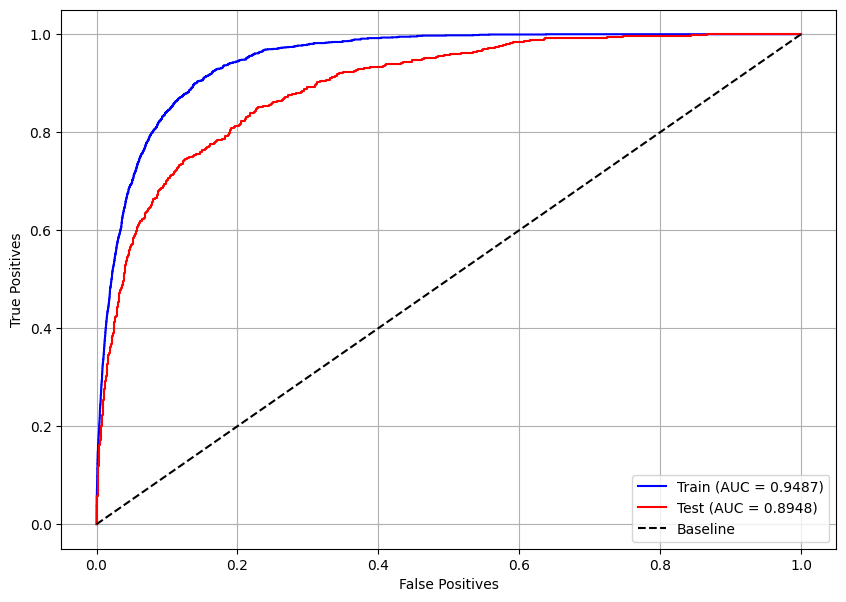

In [152]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [154]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 87,
 'max_depth': 5,
 'learning_rate': 0.11,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(17.5, 18, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

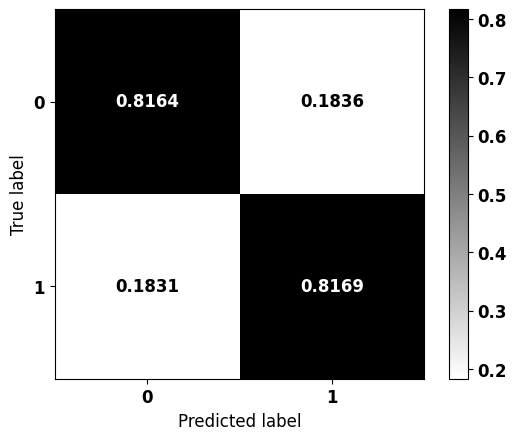


              precision    recall  f1-score   support

           0     0.9844    0.8164    0.8926      8334
           1     0.2396    0.8169    0.3705       590

    accuracy                         0.8165      8924
   macro avg     0.6120    0.8167    0.6315      8924
weighted avg     0.9351    0.8165    0.8580      8924



In [159]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:17.705}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

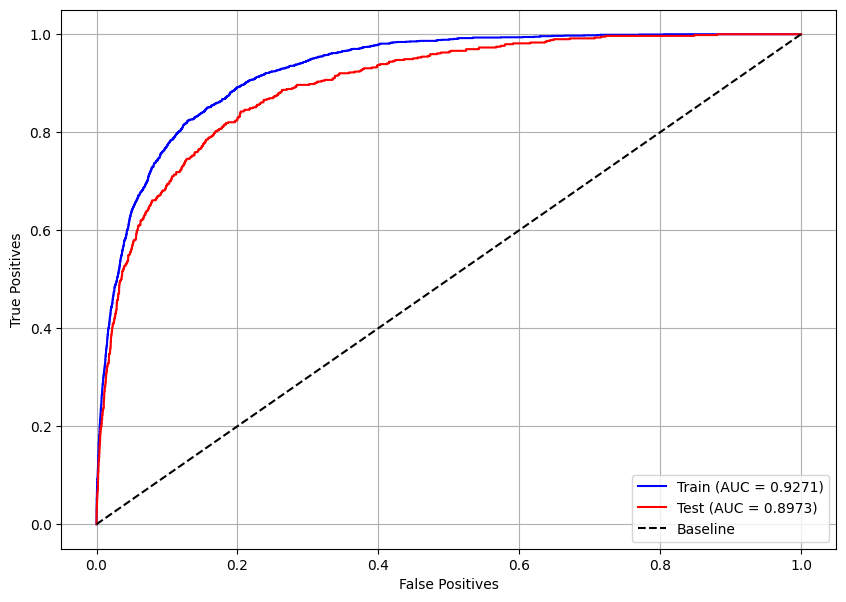

In [160]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

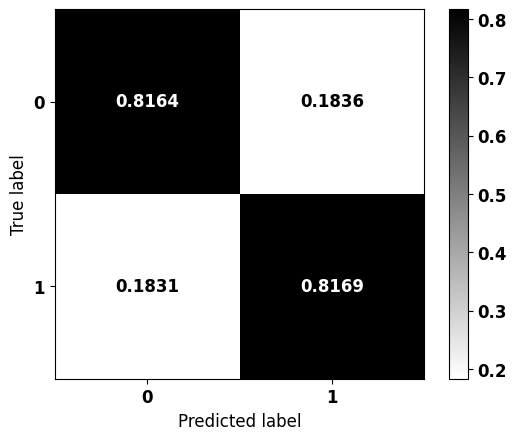


              precision    recall  f1-score   support

           0     0.9844    0.8164    0.8926      8334
           1     0.2396    0.8169    0.3705       590

    accuracy                         0.8165      8924
   macro avg     0.6120    0.8167    0.6315      8924
weighted avg     0.9351    0.8165    0.8580      8924



In [161]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 87, 'max_depth': 5, 'learning_rate': 0.11,
          'min_child_weight': 5, 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:17.705}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

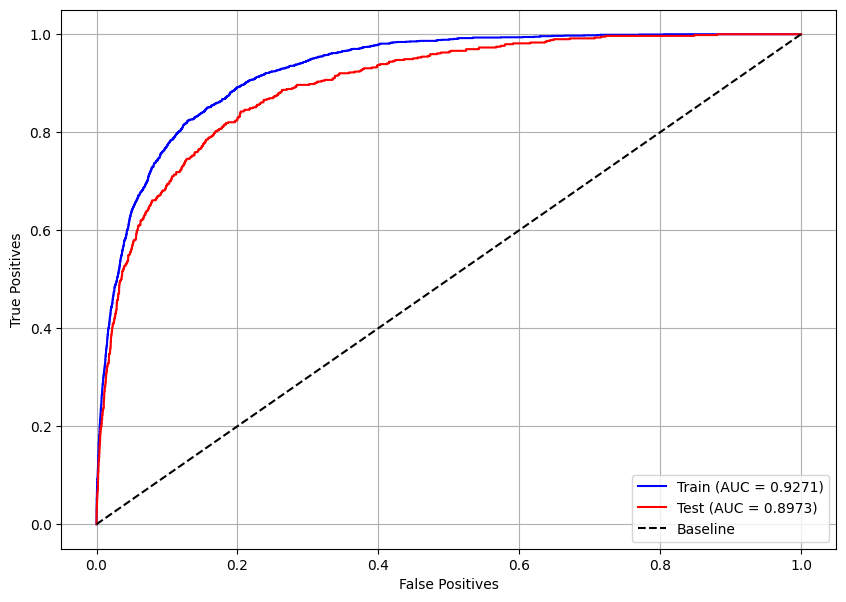

In [162]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

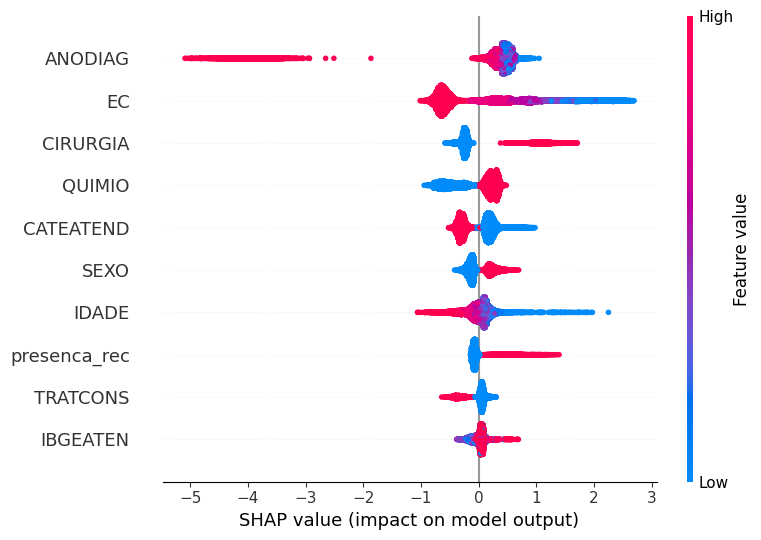

In [164]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [165]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7996, Optuna = 0.8082

Otimizado venceu


In [166]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.8079, Optuna = 0.8166

Otimizado venceu


In [167]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.8123, Optuna = 0.8165

Otimizado venceu


In [168]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 17.705}, colsample_bytree=0.5,
               learning_rate=0.11, max_depth=5, min_child_weight=5,
               n_estimators=87, random_state=7, verbose=-1)

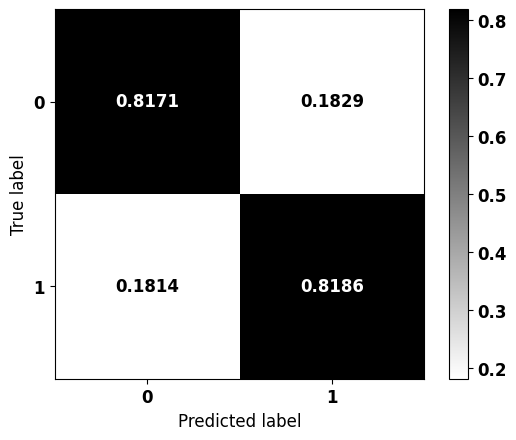


              precision    recall  f1-score   support

           0     0.9845    0.8171    0.8931      8334
           1     0.2407    0.8186    0.3720       590

    accuracy                         0.8172      8924
   macro avg     0.6126    0.8179    0.6325      8924
weighted avg     0.9354    0.8172    0.8586      8924



In [173]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

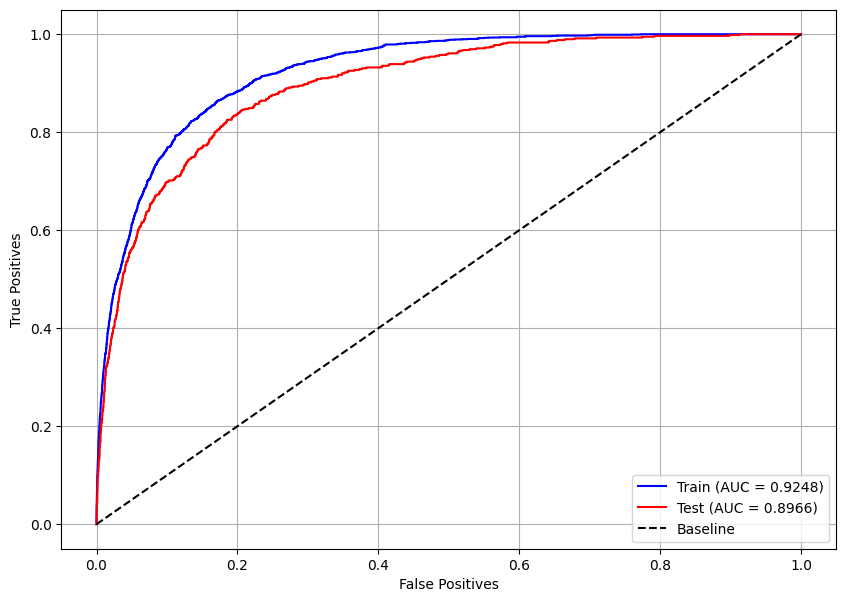

In [174]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [175]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=74, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


In [176]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano1',
 'sobrevida_ano3',
 'sobrevida_ano5']

### **Colorretal**

In [177]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


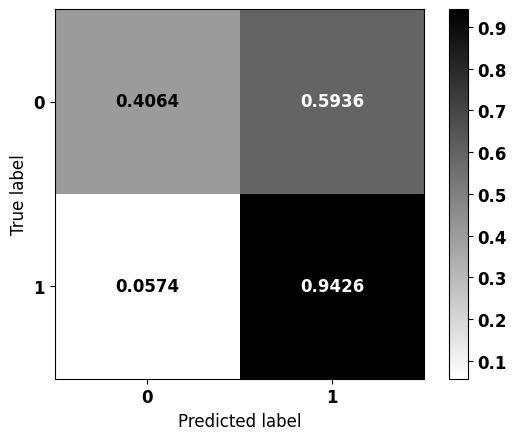


              precision    recall  f1-score   support

           0     0.9166    0.4064    0.5631     29592
           1     0.5055    0.9426    0.6581     19051

    accuracy                         0.6164     48643
   macro avg     0.7110    0.6745    0.6106     48643
weighted avg     0.7556    0.6164    0.6003     48643



In [178]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Mama**

In [179]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


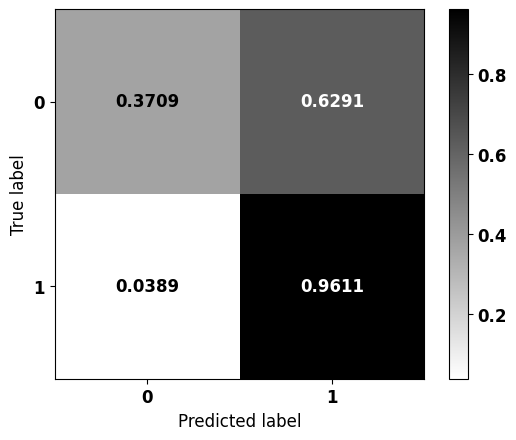


              precision    recall  f1-score   support

           0     0.8337    0.3709    0.5134     29453
           1     0.7441    0.9611    0.8388     56061

    accuracy                         0.7578     85514
   macro avg     0.7889    0.6660    0.6761     85514
weighted avg     0.7750    0.7578    0.7267     85514



In [180]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [181]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


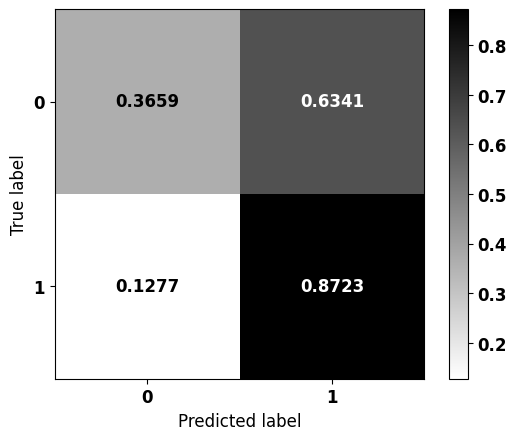


              precision    recall  f1-score   support

           0     0.7837    0.3659    0.4989     10641
           1     0.5213    0.8723    0.6526      8421

    accuracy                         0.5897     19062
   macro avg     0.6525    0.6191    0.5757     19062
weighted avg     0.6677    0.5897    0.5668     19062



In [182]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Próstata**

In [183]:
df_prostata = pd.read_csv('/content/prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


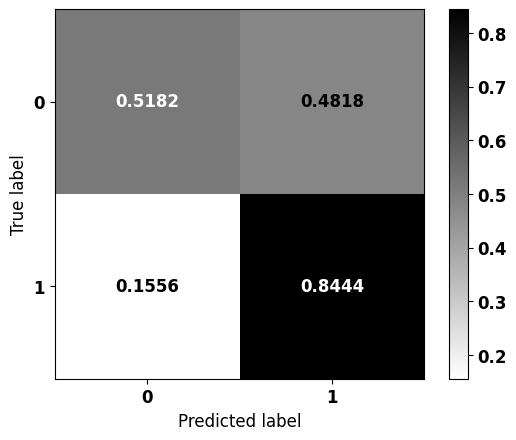


              precision    recall  f1-score   support

           0     0.5785    0.5182    0.5467     19989
           1     0.8096    0.8444    0.8266     48501

    accuracy                         0.7492     68490
   macro avg     0.6941    0.6813    0.6867     68490
weighted avg     0.7422    0.7492    0.7449     68490



In [184]:
pred_cruzada(df_prostata, best, list_drop, lb, enc, norm)

### **Pele**

In [185]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


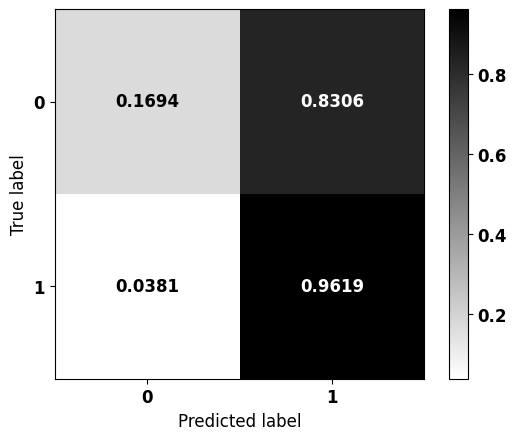


              precision    recall  f1-score   support

           0     0.7455    0.1694    0.2761     33209
           1     0.6376    0.9619    0.7669     50447

    accuracy                         0.6473     83656
   macro avg     0.6915    0.5657    0.5215     83656
weighted avg     0.6804    0.6473    0.5721     83656



In [186]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)